# Conservative Remap of Fluxes

**Note**: This uses a branch in progress `allow-degenerate` : https://github.com/JiaweiZhuang/xESMF/tree/allow-degenerate

In [40]:
%matplotlib inline

import numpy as np
import intake
import xarray as xr
import xesmf as xe

In [41]:
def _unravel(new_bounds, vertex_bounds, M, N):
    """
    Helper function to go from the vertex style to
    the M+1, N+1 style of lat/lon bounds.
    """
    new_bounds[0:N, 0:M] = vertex_bounds[:, :, 0]
    
    # fill in missing row
    new_bounds[N, 0:M] = vertex_bounds[N-1, :, 1]
    # fill in missing column
    new_bounds[0:N, M] = vertex_bounds[:, M-1, 2]
    # fill in remaining element
    new_bounds[N, M] = vertex_bounds[N-1, M-1, 3]
    return new_bounds
        

def compress_vertices(ds, lat_bnds_name='lat_b', lon_bnds_name='lon_b'):
    """
    Converts (M, N, 4) (lat/lon/vertex) bounds to
    (M+1, N+1) bounds for xESMF.
    """
    M = ds.x.size
    N = ds.y.size
    
    # create arrays for 2D bounds info
    lat_b = np.zeros((N+1, M+1))
    lon_b = np.zeros((N+1, M+1))
    
    # unravel nvertices to 2D style
    lat_b = _unravel(lat_b, ds[lat_bnds_name], M, N)
    lon_b = _unravel(lon_b, ds[lon_bnds_name], M, N)
    
    # get rid of old coordinates
    del ds[lat_bnds_name], ds[lon_bnds_name]
    ds = ds.squeeze()
    
    # assign new coordinates
    ds.coords['lat_b'] = (('y_b', 'x_b'), lat_b)
    ds.coords['lon_b'] = (('y_b', 'x_b'), lon_b)
    return ds

First attempt using the CESM2 data (which has regridded output to check against).

In [42]:
col = intake.open_esm_datastore("/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json")

In [43]:
# Just select CESM2 here for a single ensemble member.
cat = col.search(member_id='r1i1p1f1',
                 experiment_id='historical',
                 activity_id='CMIP',
                 table_id='Omon',
                 variable_id='fgco2',
                 grid_label='gn',
                 source_id='CESM2')

In [44]:
dsets = cat.to_dataset_dict()
ds = dsets['CMIP.NCAR.CESM2.historical.Omon.gn']
ds = ds.squeeze()
ds = ds.reset_coords(drop=True)


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


/glade/u/home/rbrady/miniconda3/envs/analysis/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [45]:
# Retrieve areracello
cat = col.search(variable_id='areacello',
                 activity_id='CMIP',
                 table_id='Ofx',
                 grid_label='gn',
                 source_id='CESM2',
                 member_id='r1i1p1f1',
                 experiment_id='historical')
cat.df

dsets = cat.to_dataset_dict()
area = dsets['CMIP.NCAR.CESM2.historical.Ofx.gn']


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


/glade/u/home/rbrady/miniconda3/envs/analysis/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [46]:
# Use xESMF to regrid.
ds_out = xe.util.grid_global(1, 1)
print(ds_out)

<xarray.Dataset>
Dimensions:  (x: 360, x_b: 361, y: 180, y_b: 181)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) int64 -180 -179 -178 -177 -176 ... 176 177 178 179 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*


In [60]:
ds['area'] = area['areacello'].squeeze()

ds = ds.rename({'lat_bnds': 'lat_b',
                'lon_bnds': 'lon_b',
                'nlat': 'y',
                'nlon': 'x'})
del ds['x'], ds['y']
del ds['time_bnds']
# assign bounds to coords
ds = ds.assign_coords(lat_b=ds.lat_b, lon_b=ds.lon_b)

# small time range
ds = ds.isel(time=slice(0, 3))

In [61]:
ds = compress_vertices(ds)

In [62]:
ds = ds.assign_coords(lat=ds.lat, lon=ds.lon)

In [64]:
ds = ds.load() # since we have just a few timesteps.

In [65]:
regridder = xe.Regridder(ds, ds_out, 'conservative', ignore_degenerate=True)

Overwrite existing file: conservative_384x320_180x360.nc 
 You can set reuse_weights=True to save computing time.


In [67]:
regridder.periodic = 'true'

In [68]:
regridder

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_384x320_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (384, 320) 
Output grid shape:          (180, 360) 
Output grid dimension name: ('y', 'x') 
Periodic in longitude?      true

In [69]:
dr_out = regridder(ds)

using dimensions ('y', 'x') from data variable fgco2 as the horizontal dimensions for this dataset.


In [70]:
dr_out = dr_out.compute()

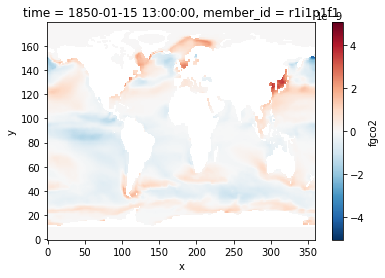

In [134]:
dr_out.isel(time=0).fgco2.plot()